# Wave Crests Detection
MIT License \
(c) 2021 Athina Lange

Enable reloading of modules for interactive development

In [1]:
%load_ext autoreload
%autoreload

Enable logging output from modules to console

In [2]:
import logging
logger = logging.getLogger()
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)

Enable matplotlib plots in the notebook

In [3]:
import matplotlib.pylab as plt
%matplotlib inline

## Datset

In [4]:
%autoreload
from dataset import WaveCrestsTimeStackDataset

samples_per_image=10  # Set to up to nx*ny of wave break region for training
sample_width=256
sample_height=256
            
datasets = {
    "train": WaveCrestsTimeStackDataset(
                images_dir="data/train/images", 
                ground_truth_dir="data/train/ground_truth",
                ground_truth_suffix="_ground_truth",
                samples_per_image=samples_per_image,
                sample_width=sample_width,
                sample_height=sample_height),
    "validate": WaveCrestsTimeStackDataset(
                    images_dir="data/validate/images", 
                    ground_truth_dir="data/validate/ground_truth",
                    ground_truth_suffix="_ground_truth",
                    samples_per_image=samples_per_image,
                    sample_width=sample_width,
                    sample_height=sample_height)
}

INFO: Created dataset with 2 wave time stack images and corresponding crest ground-truth annotation images with the following ids: 
['20200707_Torrey_10C_11_timestack', '20200707_Torrey_02C_timestack']
INFO: Created dataset with 1 wave time stack images and corresponding crest ground-truth annotation images with the following ids: 
['20200707_Torrey_10C_1_timestack']


Dataset Loader

In [5]:
from torch.utils.data import DataLoader

batch_size = 2

dataloaders = {
    "train": DataLoader(datasets["train"], 
                        batch_size=batch_size, 
                        shuffle=False,  # Set True for training
                        num_workers=8),
    "validate": DataLoader(datasets["validate"], 
                            batch_size=1, 
                            shuffle=False,
                            num_workers=8)
}

## Visualize

In [6]:
%autoreload
from visualize import plot_sample

Start iterator over dataset in batches

In [7]:
dataloader_iter = iter(dataloaders["train"])

Iterate over dataset in batches by re-running cell

{'sample idx': tensor([0, 1]), 'image id': ['20200707_Torrey_10C_11_timestack', '20200707_Torrey_10C_11_timestack'], 'x start': tensor([2351, 8724]), 'x end': tensor([2607, 8980]), 'y start': tensor([3655, 2968]), 'y end': tensor([3911, 3224])}
Batch Sample IDs: [0, 1]
Sample ID: 0


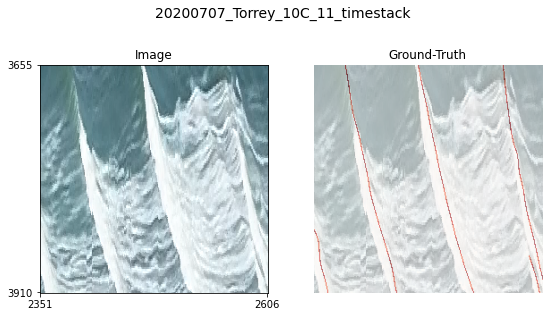

In [8]:
batch = next(dataloader_iter)
image_batch = batch["image"]
ground_truth_batch = batch["ground-truth"]
meta_batch = batch["meta"]

print(meta_batch)
print("Batch Sample IDs:", [x.item() for x in meta_batch["sample idx"]])

# sample in batch
idx = 0
image = image_batch[idx]
ground_truth = ground_truth_batch[idx]
meta = {
    "sample_idx": meta_batch["sample idx"][idx].item(),
    "image id": meta_batch["image id"][idx],
    "x start": meta_batch["x start"][idx].item(),
    "x end": meta_batch["x end"][idx].item(),
    "y start": meta_batch["y start"][idx].item(),
    "y end": meta_batch["y end"][idx].item()
}

print("Sample ID:", meta["sample_idx"])

plot_sample(image=image, meta=meta, ground_truth=ground_truth)
pass

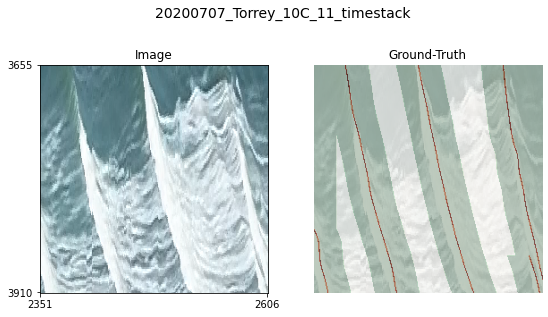

In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import torch
import kornia
                
# When the ground-truth is not provided for all objects in the image
# limit loss function to regions around ground-truth
mask_width = 50
ground_truth_mask_batch = \
    kornia.morphology.dilation(ground_truth_batch, torch.ones(1, mask_width))

ground_truth_mask = ground_truth_mask_batch[idx]
plot_sample(image=image, meta=meta, 
            ground_truth=ground_truth, 
            ground_truth_mask=ground_truth_mask)
pass

## Models

In [10]:
%autoreload
import torch

from unet_resnet18 import UNet

in_channels = 3
out_channels = 1

model = UNet()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/drh/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Model Summary

In [12]:
from pytorch_model_summary import summary

in_channels = 3
inputs = torch.ones(batch_size, in_channels, sample_height, sample_width)
print(summary(model, inputs.to(device)))

--------------------------------------------------------------------------
      Layer (type)           Output Shape         Param #     Tr. Param #
          Conv2d-1      [2, 64, 256, 256]           1,792           1,792
            ReLU-2      [2, 64, 256, 256]               0               0
          Conv2d-3      [2, 64, 256, 256]          36,928          36,928
            ReLU-4      [2, 64, 256, 256]               0               0
          Conv2d-5      [2, 64, 128, 128]           9,408           9,408
     BatchNorm2d-6      [2, 64, 128, 128]             128             128
            ReLU-7      [2, 64, 128, 128]               0               0
       MaxPool2d-8        [2, 64, 64, 64]               0               0
      BasicBlock-9        [2, 64, 64, 64]          73,984          73,984
     BasicBlock-10        [2, 64, 64, 64]          73,984          73,984
     BasicBlock-11       [2, 128, 32, 32]         230,144         230,144
     BasicBlock-12       [2, 128, 32,